In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.cm as cm
import pmdarima as pm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

# 2 Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias 

In [2]:
#agbarometer

df_agbarometer = pd.read_csv('../data/clean_data/agbarometer_cleaned.csv')
print(df_agbarometer.head(10))

     Bimestre  CondicIones presentes  Expectativas futuras  Ag Barometer
0  2018-11-01                     43                   130            95
1  2019-01-01                     59                   137           106
2  2019-03-01                     69                   126           103
3  2019-05-01                     82                   141           117
4  2019-07-01                    105                   158           137
5  2019-09-01                     64                    80            74
6  2019-11-01                     64                    64            64
7  2020-01-01                     46                    56            52
8  2020-04-01                     50                    54            53
9  2020-07-01                     52                    45            48


In [3]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Bimestre               41 non-null     object
 1   CondicIones presentes  41 non-null     int64 
 2   Expectativas futuras   41 non-null     int64 
 3   Ag Barometer           41 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ KB


In [4]:
print(df_agbarometer['Bimestre'].head())

0    2018-11-01
1    2019-01-01
2    2019-03-01
3    2019-05-01
4    2019-07-01
Name: Bimestre, dtype: object


In [5]:
df_agbarometer['Bimestre'] = pd.to_datetime(df_agbarometer['Bimestre'], format='%Y-%m-%d')
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bimestre               41 non-null     datetime64[ns]
 1   CondicIones presentes  41 non-null     int64         
 2   Expectativas futuras   41 non-null     int64         
 3   Ag Barometer           41 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 KB


In [6]:
df_agbarometer.set_index('Bimestre', inplace=True)
df_agbarometer.head()

,CondicIones presentes,Expectativas futuras,Ag Barometer
Bimestre,,,
2018-11-01,43,130,95
2019-01-01,59,137,106
2019-03-01,69,126,103
2019-05-01,82,141,117
2019-07-01,105,158,137


In [7]:
df_agbarometer.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2018-11-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   CondicIones presentes  41 non-null     int64
 1   Expectativas futuras   41 non-null     int64
 2   Ag Barometer           41 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


In [8]:
data1 = df_agbarometer['Ag Barometer']

In [9]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 29 y 62 dias

df_time_diffs = data1.index.to_series().diff()
print(df_time_diffs.value_counts())

Bimestre
61 days    25
62 days     7
59 days     5
91 days     2
60 days     1
Name: count, dtype: int64


In [10]:
# Vemos que hay dos intervalos de 91 dias

In [11]:
# Filtrar los bimestres con diferencia de 91 días
filtered_91 = df_time_diffs[df_time_diffs == pd.Timedelta(days=91)]
print(filtered_91)

Bimestre
2020-04-01   91 days
2020-07-01   91 days
Name: Bimestre, dtype: timedelta64[ns]


In [12]:
# Buscamos los indices de esos bimestres
indices_91 = filtered_91.index

for idx in indices_91:
    if idx not in df_agbarometer.index:
        print(f"\n{idx} no se encuentra en df_agbarometer")
        continue
    pos = df_agbarometer.index.get_loc(idx)
    start = max(0, pos - 2)
    end = min(len(df_agbarometer) - 2, pos + 2)
    print(f"\n--- Contexto alrededor de {idx.date()} (posición {pos}) ---")
    print(df_agbarometer.iloc[start:end+2])


--- Contexto alrededor de 2020-04-01 (posición 8) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2019-11-01                     64                    64            64
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                    45            48
2020-09-01                     74                    65            69
2020-11-01                     76                    80            78

--- Contexto alrededor de 2020-07-01 (posición 9) ---
            CondicIones presentes  Expectativas futuras  Ag Barometer
Bimestre                                                             
2020-01-01                     46                    56            52
2020-04-01                     50                    54            53
2020-07-01                     52                 

Vemos que lo que ha pasado es un desfazaje en los meses de pandemia. Deberiamos tener 2020-03, 2020-05 y 2020-07.
En su lugar, tenemos solo 2020-04. Se decide interpolar los valores faltantes y eliminar el 2020-04 para evitar ruido en periodicidad

In [13]:
# Valores para interpolar
valor_2020_01_01 = data1.loc['2020-01-01'] 
valor_2020_04_01 = data1.loc['2020-04-01'] 
valor_2020_07_01 = data1.loc['2020-07-01'] 

# Calcular los promedios
valor_promedio_2020_03_01 = (valor_2020_01_01 + valor_2020_04_01) / 2 

valor_promedio_2020_05_01 = (valor_2020_04_01 + valor_2020_07_01) / 2 

# Agregar los datos
fecha_a_insertar_1 = pd.to_datetime('2020-03-01')
fecha_a_insertar_2 = pd.to_datetime('2020-05-01')

data1.loc[fecha_a_insertar_1] = valor_promedio_2020_03_01
data1.loc[fecha_a_insertar_2] = valor_promedio_2020_05_01

# Eliminar dato de abril
fecha_a_eliminar = pd.to_datetime('2020-04-01')
data1 = data1.drop(fecha_a_eliminar)

# Ordenar la Serie por índice 
data1 = data1.sort_index()
print(data1.loc['2019-11-01':'2020-11-01'])

Bimestre
2019-11-01    64.0
2020-01-01    52.0
2020-03-01    52.5
2020-05-01    50.5
2020-07-01    48.0
2020-09-01    69.0
2020-11-01    78.0
Name: Ag Barometer, dtype: float64


In [14]:
# Asignamos frecuencia bimestral
data1 = data1.asfreq('2MS')

# Corroboramos que la frecuencia sea bimestral
print(data1.index)

DatetimeIndex(['2018-11-01', '2019-01-01', '2019-03-01', '2019-05-01',
               '2019-07-01', '2019-09-01', '2019-11-01', '2020-01-01',
               '2020-03-01', '2020-05-01', '2020-07-01', '2020-09-01',
               '2020-11-01', '2021-01-01', '2021-03-01', '2021-05-01',
               '2021-07-01', '2021-09-01', '2021-11-01', '2022-01-01',
               '2022-03-01', '2022-05-01', '2022-07-01', '2022-09-01',
               '2022-11-01', '2023-01-01', '2023-03-01', '2023-05-01',
               '2023-07-01', '2023-09-01', '2023-11-01', '2024-01-01',
               '2024-03-01', '2024-05-01', '2024-07-01', '2024-09-01',
               '2024-11-01', '2025-01-01', '2025-03-01', '2025-05-01',
               '2025-07-01', '2025-09-01'],
              dtype='datetime64[ns]', name='Bimestre', freq='2MS')


In [15]:
# Dividimos en train y test
# Seleccionamos el primer 90% para train
train1 = data1.iloc[:round(len(data1)*.9)]
# Seleccionamos el 10% restante para test
test1 = data1.iloc[round(len(data1)*.9):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train1, test1)

Bimestre
2018-11-01     95.0
2019-01-01    106.0
2019-03-01    103.0
2019-05-01    117.0
2019-07-01    137.0
2019-09-01     74.0
2019-11-01     64.0
2020-01-01     52.0
2020-03-01     52.5
2020-05-01     50.5
2020-07-01     48.0
2020-09-01     69.0
2020-11-01     78.0
2021-01-01     79.0
2021-03-01     90.0
2021-05-01     79.0
2021-07-01     69.0
2021-09-01     79.0
2021-11-01     79.0
2022-01-01     90.0
2022-03-01     90.0
2022-05-01     98.0
2022-07-01     76.0
2022-09-01     83.0
2022-11-01     67.0
2023-01-01     68.0
2023-03-01     69.0
2023-05-01     84.0
2023-07-01     89.0
2023-09-01    100.0
2023-11-01    117.0
2024-01-01    119.0
2024-03-01    129.0
2024-05-01    139.0
2024-07-01    139.0
2024-09-01    132.0
2024-11-01    149.0
2025-01-01    117.0
Freq: 2MS, Name: Ag Barometer, dtype: float64 Bimestre
2025-03-01    137.0
2025-05-01    130.0
2025-07-01    127.0
2025-09-01    124.0
Freq: 2MS, Name: Ag Barometer, dtype: float64


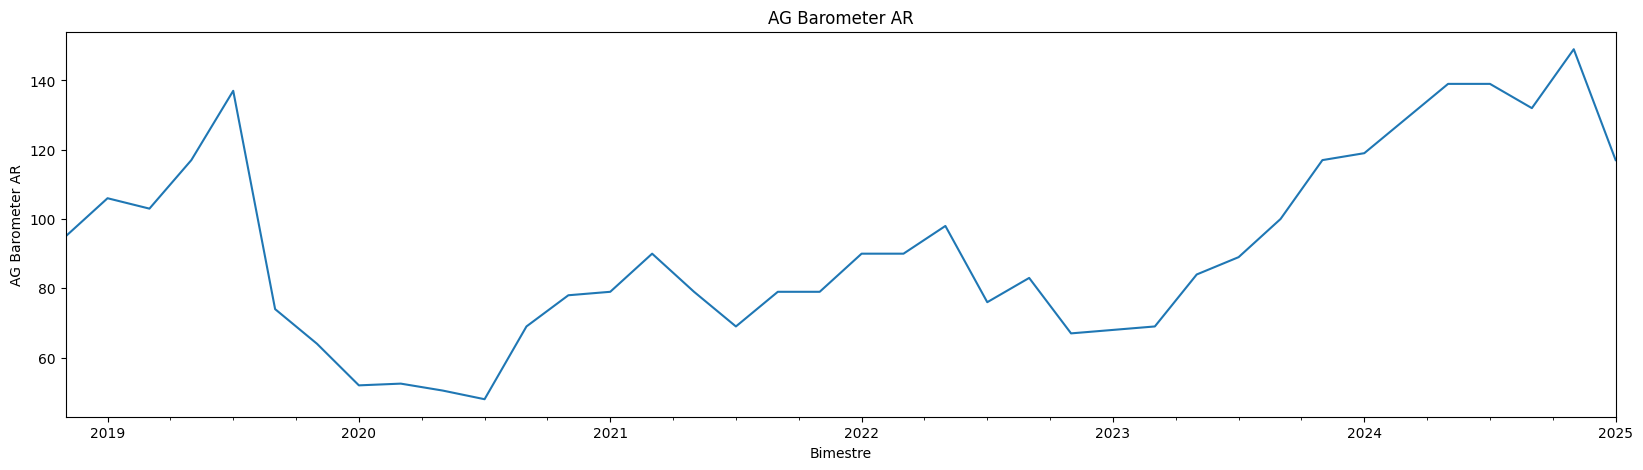

In [16]:
train1.plot(figsize=(20,5), title = "AG Barometer AR", ylabel = "AG Barometer AR", xlabel = "Bimestre")
plt.show()

In [17]:
#ageconomy

df_ageconomy = pd.read_csv('../data/clean_data/AgEconomyBarometer_cleaned.csv')
print(df_ageconomy.head())

      Month  Year  Purdue/CME Ag Economy Barometer  \
0   October  2015                              116   
1  November  2015                               97   
2  December  2015                              107   
3   January  2016                               98   
4  February  2016                               96   

   Index of Current Conditions  Index of Future Expectations  \
0                          118                           116   
1                           98                            97   
2                          125                            98   
3                           99                            98   
4                           82                           102   

   Farm Capital Investment Index  
0                             67  
1                             51  
2                             75  
3                             52  
4                             56  


In [18]:
df_ageconomy['Date'] = df_ageconomy['Year'].astype(str) + '-' + df_ageconomy['Month'].astype(str).str.zfill(2) + '-01'
df_ageconomy['Date'] = pd.to_datetime(df_ageconomy['Date'])

In [19]:
df_ageconomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Month                            121 non-null    object        
 1   Year                             121 non-null    int64         
 2   Purdue/CME Ag Economy Barometer  121 non-null    int64         
 3   Index of Current Conditions      121 non-null    int64         
 4   Index of Future Expectations     121 non-null    int64         
 5   Farm Capital Investment Index    121 non-null    int64         
 6   Date                             121 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 6.7+ KB


In [20]:
df_ageconomy.set_index('Date', inplace=True)
df_ageconomy.head()

,Month,Year,Purdue/CME Ag Economy Barometer,Index of Current Conditions,Index of Future Expectations,Farm Capital Investment Index
Date,,,,,,
2015-10-01,October,2015,116,118,116,67
2015-11-01,November,2015,97,98,97,51
2015-12-01,December,2015,107,125,98,75
2016-01-01,January,2016,98,99,98,52
2016-02-01,February,2016,96,82,102,56


In [21]:
data2 = df_ageconomy['Purdue/CME Ag Economy Barometer']

In [22]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 28 y 31 dias

df_time_diffs = data2.index.to_series().diff()
print(df_time_diffs.value_counts())

Date
31 days    70
30 days    40
28 days     7
29 days     3
Name: count, dtype: int64


In [23]:
# Asignamos frecuencia mensual
data2 = data2.asfreq('MS')

# Corroboramos que la frecuencia sea mensual
print(data2.index)

DatetimeIndex(['2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01',
               ...
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', name='Date', length=121, freq='MS')


In [24]:
# Dividimos en train y test
# Seleccionamos el primer 80% para train
train2 = data2.iloc[:round(len(data2)*.8)]
# Seleccionamos el 20% restante para test
test2 = data2.iloc[round(len(data2)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train2, test2)

Date
2015-10-01    116
2015-11-01     97
2015-12-01    107
2016-01-01     98
2016-02-01     96
             ... 
2023-06-01    121
2023-07-01    123
2023-08-01    115
2023-09-01    106
2023-10-01    110
Freq: MS, Name: Purdue/CME Ag Economy Barometer, Length: 97, dtype: int64 Date
2023-11-01    115
2023-12-01    114
2024-01-01    106
2024-02-01    111
2024-03-01    114
2024-04-01     99
2024-05-01    108
2024-06-01    105
2024-07-01    113
2024-08-01    100
2024-09-01     88
2024-10-01    115
2024-11-01    145
2024-12-01    136
2025-01-01    141
2025-02-01    152
2025-03-01    140
2025-04-01    148
2025-05-01    158
2025-06-01    146
2025-07-01    135
2025-08-01    125
2025-09-01    126
2025-10-01    129
Freq: MS, Name: Purdue/CME Ag Economy Barometer, dtype: int64


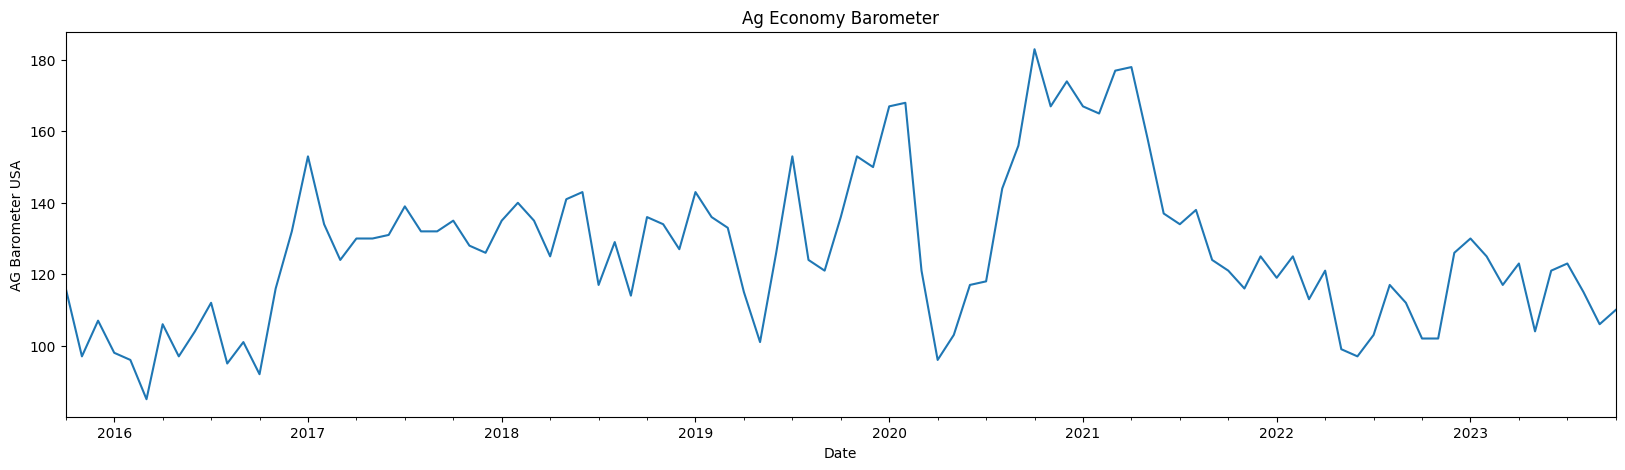

In [111]:
train2.plot(figsize=(20,5), title = "Ag Economy Barometer", ylabel = "AG Barometer USA", xlabel = "Date")
plt.show()

In [26]:
#ICG UTDT

df_ICG = pd.read_csv('../data/clean_data/ICG_cleaned.csv')
print(df_ICG.head())

  indicator        date  value
0       ICG  2001-11-01  1.036
1       ICG  2001-12-01  0.757
2       ICG  2002-01-01  1.357
3       ICG  2002-02-01  0.983
4       ICG  2002-03-01  0.862


In [27]:
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   indicator  288 non-null    object 
 1   date       288 non-null    object 
 2   value      288 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.9+ KB


In [28]:
df_ICG['date'] = pd.to_datetime(df_ICG['date'], format='%Y-%m-%d')
df_ICG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   indicator  288 non-null    object        
 1   date       288 non-null    datetime64[ns]
 2   value      288 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.9+ KB


In [29]:
df_ICG.set_index('date', inplace=True)
print(df_ICG.head())

           indicator  value
date                       
2001-11-01       ICG  1.036
2001-12-01       ICG  0.757
2002-01-01       ICG  1.357
2002-02-01       ICG  0.983
2002-03-01       ICG  0.862


In [30]:
data3 = df_ICG['value']

In [31]:
# Checkeamos que los datos esten en intervalos regulares. Como con datetime no tenemos una frecuencia definida debería tener entre 28 y 31 dias

df_time_diffs = data3.index.to_series().diff()
print(df_time_diffs.value_counts())

date
31 days    167
30 days     96
28 days     18
29 days      6
Name: count, dtype: int64


In [32]:
# Asignamos frecuencia mensual
data3 = data3.asfreq('MS')

# Corroboramos que la frecuencia sea mensual
print(data3.index)

DatetimeIndex(['2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01',
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01',
               ...
               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', name='date', length=288, freq='MS')


In [33]:
# Dividimos en train y test
# Seleccionamos el primer 80% para train
train3 = data3.iloc[:round(len(data3)*.8)]
# Seleccionamos el 20% restante para test
test3 = data3.iloc[round(len(data3)*.8):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train3, test3)

date
2001-11-01    1.036000
2001-12-01    0.757000
2002-01-01    1.357000
2002-02-01    0.983000
2002-03-01    0.862000
                ...   
2020-08-01    2.377858
2020-09-01    2.265969
2020-10-01    1.992344
2020-11-01    2.019343
2020-12-01    1.853868
Freq: MS, Name: value, Length: 230, dtype: float64 date
2021-01-01    1.875130
2021-02-01    1.816565
2021-03-01    1.783856
2021-04-01    1.732998
2021-05-01    1.932057
2021-06-01    1.703405
2021-07-01    1.698242
2021-08-01    1.852228
2021-09-01    1.579328
2021-10-01    1.524077
2021-11-01    1.453584
2021-12-01    1.422823
2022-01-01    1.543808
2022-02-01    1.494021
2022-03-01    1.507731
2022-04-01    1.436073
2022-05-01    1.303236
2022-06-01    1.401616
2022-07-01    1.116667
2022-08-01    1.182577
2022-09-01    1.230554
2022-10-01    1.281745
2022-11-01    1.189553
2022-12-01    1.251266
2023-01-01    1.274121
2023-02-01    1.171330
2023-03-01    1.177622
2023-04-01    1.070521
2023-05-01    1.132271
2023-06-01    1.119

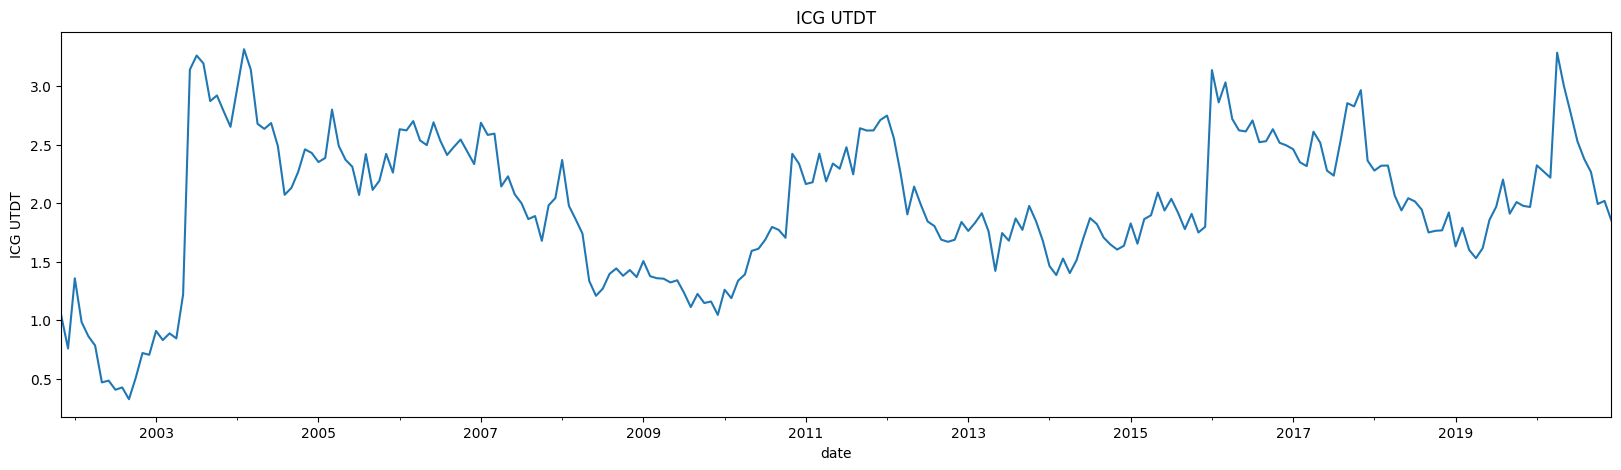

In [34]:
train3.plot(figsize=(20,5), title = "ICG UTDT", ylabel = "ICG UTDT", xlabel = "date")
plt.show()

En este apartado se presentan las siguientes series, en orden:

- Ag Barometer AR
- Ag Barometer USA
- ICG

La primera parece tener una componente de tendencia, aparentemente lineal, lo que implicaría que la serie no es estacionaria. Pero al tener esta leve tendencia y, visualmente, no notarse ciclos, con una diferenciación tal vez pueda ser necesario para hacer a la misma estacionaria.

Para Ag Baromemter USA, la seria aparenta ser estacionaria. Tal vez puede existir una leve componente de tendencia o alguna variación en variabilidad pero, a priori, se asemeja mucho a una estacionaria. Para ese caso no necesitariamos diferenciación.

Por otro lado, tenemos el ICG, que a simple vista no parece ser estacionaria. Si bien podriamos pensar en cierta oscilación sobre una valor medio, parece tener ciclos de picos y valles, con saltos absolutos marcados sobre años de elecciones presidenciales. En este caso, una prueba a hacer sería diferenciar entre los valores del ciclo, para reducir dicha estacionalidad.

In [35]:
# Serie a data frame
df_ciclos = train3.to_frame(name='ICG')

# Filtrado
fecha_inicio_ciclos = pd.to_datetime('2003-12-01')
df_ciclos = df_ciclos.loc[df_ciclos.index >= fecha_inicio_ciclos].copy()

# Construcción de los gobiernos
diff_meses = (
    (df_ciclos.index.year - fecha_inicio_ciclos.year) * 12 +
    (df_ciclos.index.month - fecha_inicio_ciclos.month)
)

periodo_ciclo = 48 # 4 años * 12 meses

df_ciclos['Ciclo'] = (diff_meses // periodo_ciclo) + 1

condiciones = [
    (df_ciclos['Ciclo'] == 1),
    (df_ciclos['Ciclo'] == 2),
    (df_ciclos['Ciclo'] == 3),
    (df_ciclos['Ciclo'] == 4),
    (df_ciclos['Ciclo'] == 5),
    (df_ciclos['Ciclo'] == 6)        
                 
]

valores_salida = ['NK', 'CFK 1', 'CFK 2', 'Macri', 'Alberto', 'Milei']

df_ciclos['Ciclo'] = np.select(
    condiciones, 
    valores_salida,
    default = 'NA'
)

df_ciclos['Mes_en_Ciclo'] = (diff_meses % periodo_ciclo) + 1


# Chequeo
print("--- DataFrame con Ciclos de 4 Años (Meses 1, 47, 48) ---")
print(df_ciclos[['ICG', 'Ciclo', 'Mes_en_Ciclo']].head(50)) 
print("\n--- Final del Último Ciclo ---")
print(df_ciclos[['ICG', 'Ciclo', 'Mes_en_Ciclo']].tail(5))

--- DataFrame con Ciclos de 4 Años (Meses 1, 47, 48) ---
                 ICG  Ciclo  Mes_en_Ciclo
date                                     
2003-12-01  2.652758     NK             1
2004-01-01  2.985494     NK             2
2004-02-01  3.316432     NK             3
2004-03-01  3.141597     NK             4
2004-04-01  2.678145     NK             5
2004-05-01  2.635284     NK             6
2004-06-01  2.684965     NK             7
2004-07-01  2.488041     NK             8
2004-08-01  2.071303     NK             9
2004-09-01  2.130540     NK            10
2004-10-01  2.267291     NK            11
2004-11-01  2.460088     NK            12
2004-12-01  2.429269     NK            13
2005-01-01  2.351252     NK            14
2005-02-01  2.386628     NK            15
2005-03-01  2.799647     NK            16
2005-04-01  2.489071     NK            17
2005-05-01  2.370627     NK            18
2005-06-01  2.311147     NK            19
2005-07-01  2.069969     NK            20
2005-08-01  2.42008

C:\Users\FBorbiconi\AppData\Local\Temp\ipykernel_16208\1738518073.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Spectral', num_ciclos)


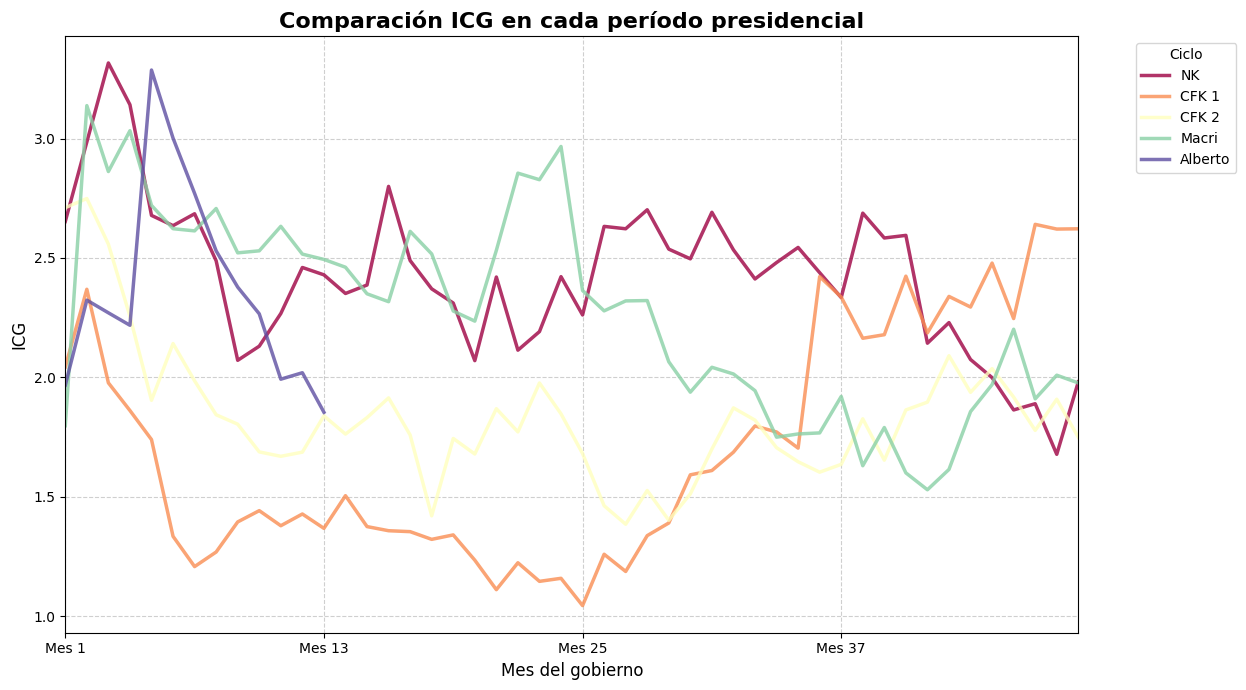

In [36]:


# Obtener los ciclos únicos para iterar y asignar colores
ciclos_unicos = df_ciclos['Ciclo'].unique()
num_ciclos = len(ciclos_unicos)

# Usar un mapa de colores (colormap) de Matplotlib (e.g., 'viridis', 'tab10', 'Spectral')
colors = cm.get_cmap('Spectral', num_ciclos) 

# Construcción del gráfico
plt.figure(figsize=(14, 7))
ax = plt.gca() # Obtener el objeto axes actual

# Iterar y Graficar cada Ciclo
for i, ciclo in enumerate(ciclos_unicos):

    data_ciclo = df_ciclos[df_ciclos['Ciclo'] == ciclo]
    
    ax.plot(
        data_ciclo['Mes_en_Ciclo'], 
        data_ciclo['ICG'],       
        label=f'{ciclo}',    
        color=colors(i),            
        linewidth=2.5,
        alpha=0.8
    )

# Configuración del Gráfico
plt.title('Comparación ICG en cada período presidencial', fontsize=16, fontweight='bold')
plt.xlabel('Mes del gobierno', fontsize=12)
plt.ylabel('ICG', fontsize=12)


meses_anuales = [1, 13, 25, 37]
plt.xticks(meses_anuales, [f'Mes {m}' for m in meses_anuales])
plt.xlim(1, 48)


plt.legend(title='Ciclo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# 3 Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría. 

In [37]:
# Grafica de ACF, PACF y autocovarianza
def graficar_acf_pacf_autocovarianza(data, lags=10):
    Y = data.values

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))


    sm.graphics.tsa.plot_acf(Y, lags=lags, ax=ax[0])
    ax[0].set_title('Funcion de autocorrelación (ACF)')

    sm.graphics.tsa.plot_pacf(Y, lags=lags, ax=ax[1])
    ax[1].set_title('Funcion de autocorrelación Parcial (grafico introductorio) (PACF)')

    def autocovariance(series, lag):
        series_mean = np.mean(series)
        n = len(series)
        return np.sum((series[:n-lag] - series_mean) * (series[lag:] - series_mean)) / n

    lags = np.arange(lags)
    autocov = [autocovariance(Y, lag) for lag in lags]

    ax[2].stem(lags, autocov)
    ax[2].set_title('Autocovarianza')
    ax[2].set_xlabel('Lag')
    ax[2].set_ylabel('Autocovarianza')

    plt.tight_layout();
    plt.show();

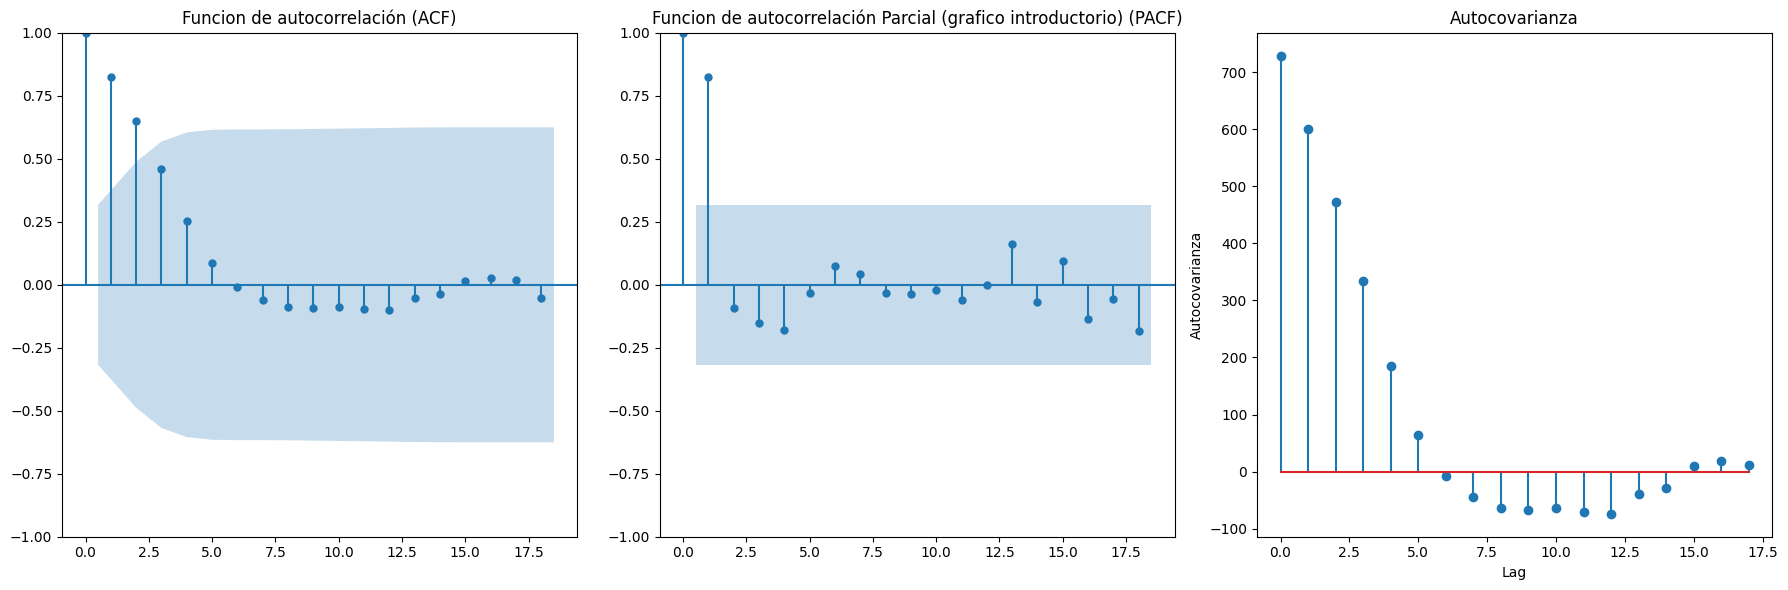

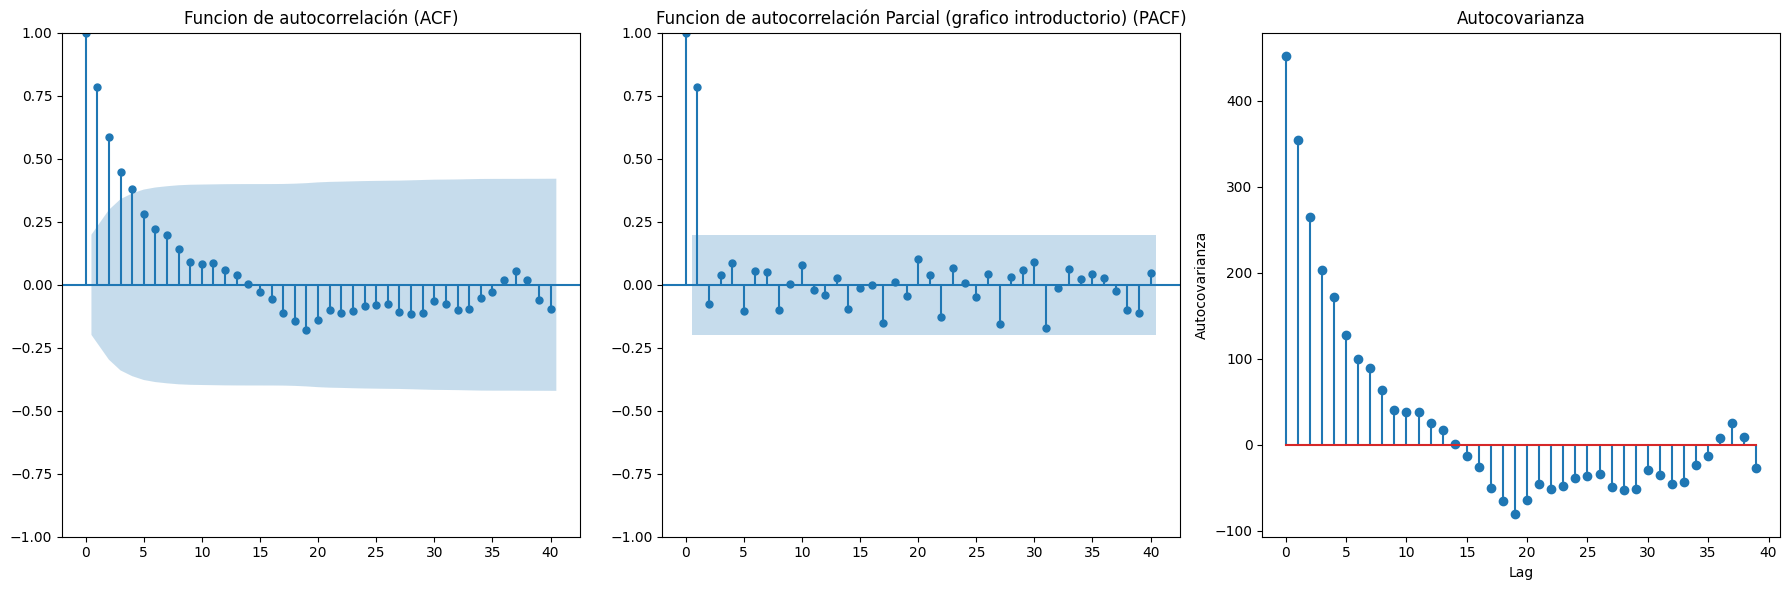

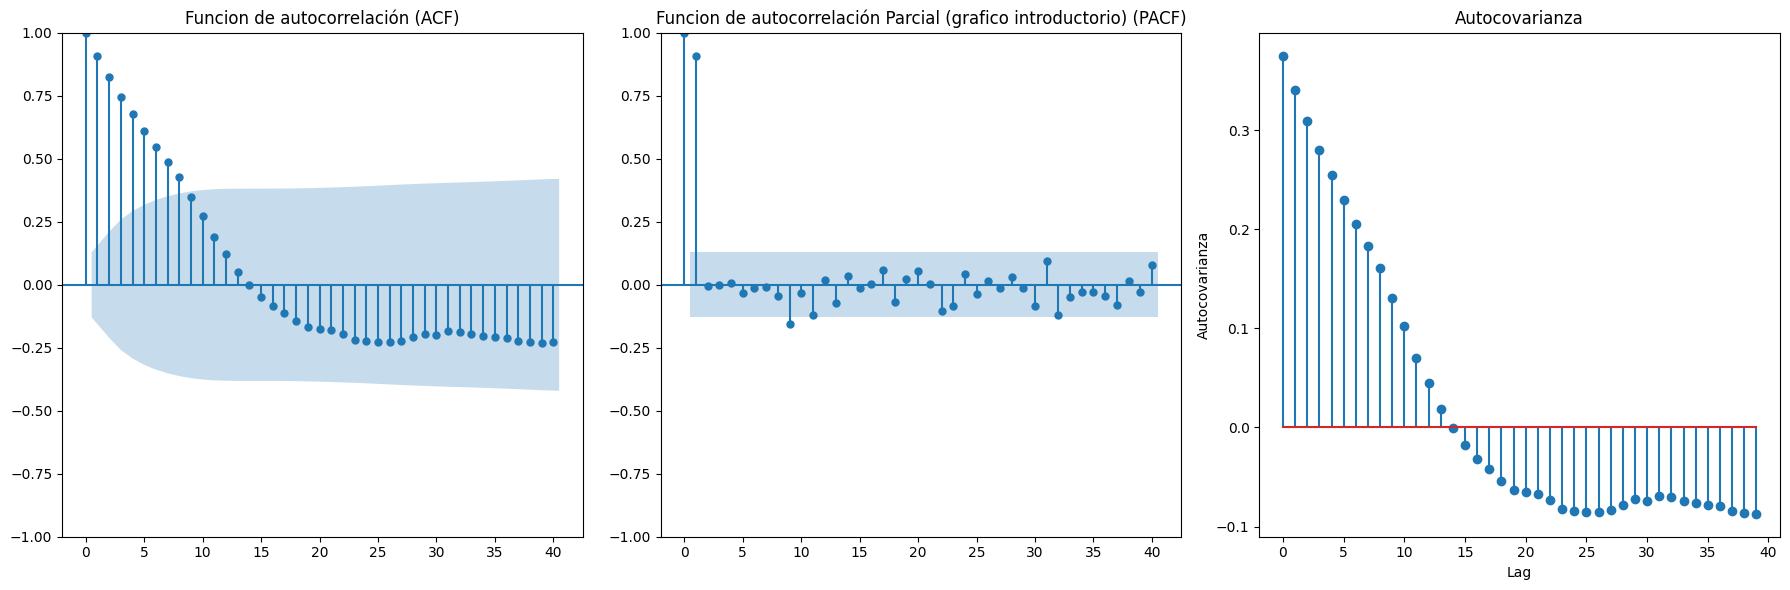

In [38]:
graficar_acf_pacf_autocovarianza(train1, lags=18)
graficar_acf_pacf_autocovarianza(train2, lags=40)
graficar_acf_pacf_autocovarianza(train3, lags=40)

En el caso del Ag Barometer AR podemos ver un decaimiento que aparenta ser lineal, lo que ya nos puede hacer pensar en que no tenemos estacionariedad. A su vez, vemos una fuerte autocorrelación parcial con el primer rezago, haciendonos pensar en una componente autorregresiva de orden 1.

El caso del Ag Barometer USA podría indicarnos una serie estacionaria, donde se nota un decaimiento exponencial en el correlograma, con memoria relativamente corta. A su vez, otra vez visualizando la autocorrelación parcial, podemos pensar en una autocorrelación de orden 1. Con todo esto, pensamos que un primer modelo de aproximación podría ser un AR(1)

Para el caso del ICG, vemos más una caida lineal de la autocorrelación y algunos rezagos estadísticamente significativos en la autocorrelación parcial. Este es el caso más dificil de interpretar, ya que la supuesta estacionalidad marcada tampoco se ve muy notoriamente en estos gráficos

In [39]:
def print_test_afd(y):
  resultado = tsa.adfuller(y)
  print('Estadistico ADF: %f' % resultado[0])
  print('p-valor: %f' % resultado[1])
  print('Valores criticos:')
  for key, valor in resultado[4].items():
    print('\t%s: %.3f' % (key, valor))

In [40]:
print_test_afd(train1)
print_test_afd(train2)
print_test_afd(train3)

Estadistico ADF: -1.269719
p-valor: 0.642910
Valores criticos:
	1%: -3.654
	5%: -2.957
	10%: -2.618
Estadistico ADF: -3.310231
p-valor: 0.014427
Valores criticos:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Estadistico ADF: -3.409435
p-valor: 0.010641
Valores criticos:
	1%: -3.459
	5%: -2.874
	10%: -2.574


Recordando que el test de Dickey-Fuller involucra:

- H0: existencia de raiz unitaria
- Ha: no existencia de raiz unitaria

Dados los p valores de los test a las 3 series, podemos decir que:

- Para AG Barometer AR, no podemos rechazar la H0, o sea, la no estacionariedad
- Para AG Barometer USA e ICG, se presenta evidencia estadística para rechazar H0 y afirmar que presentan estacionariedad

In [41]:
# Diferenciación de la serie del Agbarometer AR
data1_diferenciada = data1 - data1.shift(1)

# eliminamos el NA inicial
data1_diferenciada = data1_diferenciada.dropna()

# Dividimos en train y test
# Seleccionamos el primer 90% para train
train1_dif = data1_diferenciada.iloc[:round(len(data1)*.9)]
# Seleccionamos el 10% restante para test
test1_dif = data1_diferenciada.iloc[round(len(data1)*.9):]
# Corroboramos que los limites se hayan establecido segun lo planificado
print(train1_dif, test1_dif)

Bimestre
2019-01-01    11.0
2019-03-01    -3.0
2019-05-01    14.0
2019-07-01    20.0
2019-09-01   -63.0
2019-11-01   -10.0
2020-01-01   -12.0
2020-03-01     0.5
2020-05-01    -2.0
2020-07-01    -2.5
2020-09-01    21.0
2020-11-01     9.0
2021-01-01     1.0
2021-03-01    11.0
2021-05-01   -11.0
2021-07-01   -10.0
2021-09-01    10.0
2021-11-01     0.0
2022-01-01    11.0
2022-03-01     0.0
2022-05-01     8.0
2022-07-01   -22.0
2022-09-01     7.0
2022-11-01   -16.0
2023-01-01     1.0
2023-03-01     1.0
2023-05-01    15.0
2023-07-01     5.0
2023-09-01    11.0
2023-11-01    17.0
2024-01-01     2.0
2024-03-01    10.0
2024-05-01    10.0
2024-07-01     0.0
2024-09-01    -7.0
2024-11-01    17.0
2025-01-01   -32.0
2025-03-01    20.0
Freq: 2MS, Name: Ag Barometer, dtype: float64 Bimestre
2025-05-01   -7.0
2025-07-01   -3.0
2025-09-01   -3.0
Freq: 2MS, Name: Ag Barometer, dtype: float64


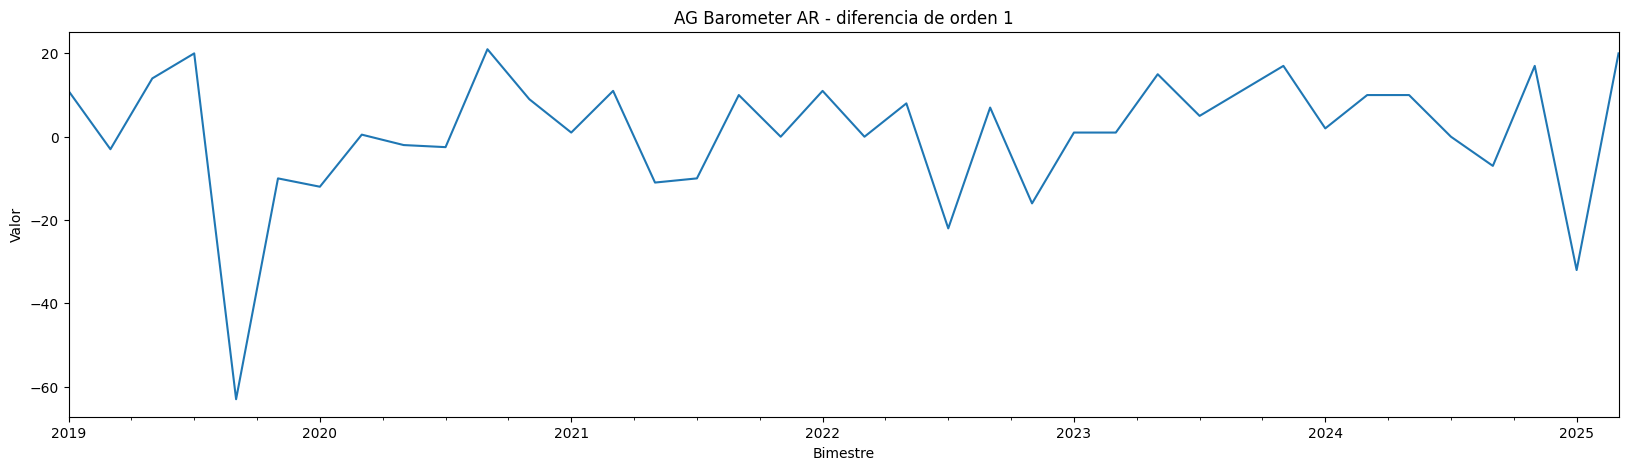

In [42]:
train1_dif.plot(figsize=(20,5), title = "AG Barometer AR - diferencia de orden 1", ylabel = "Valor", xlabel = "Bimestre")
plt.show()

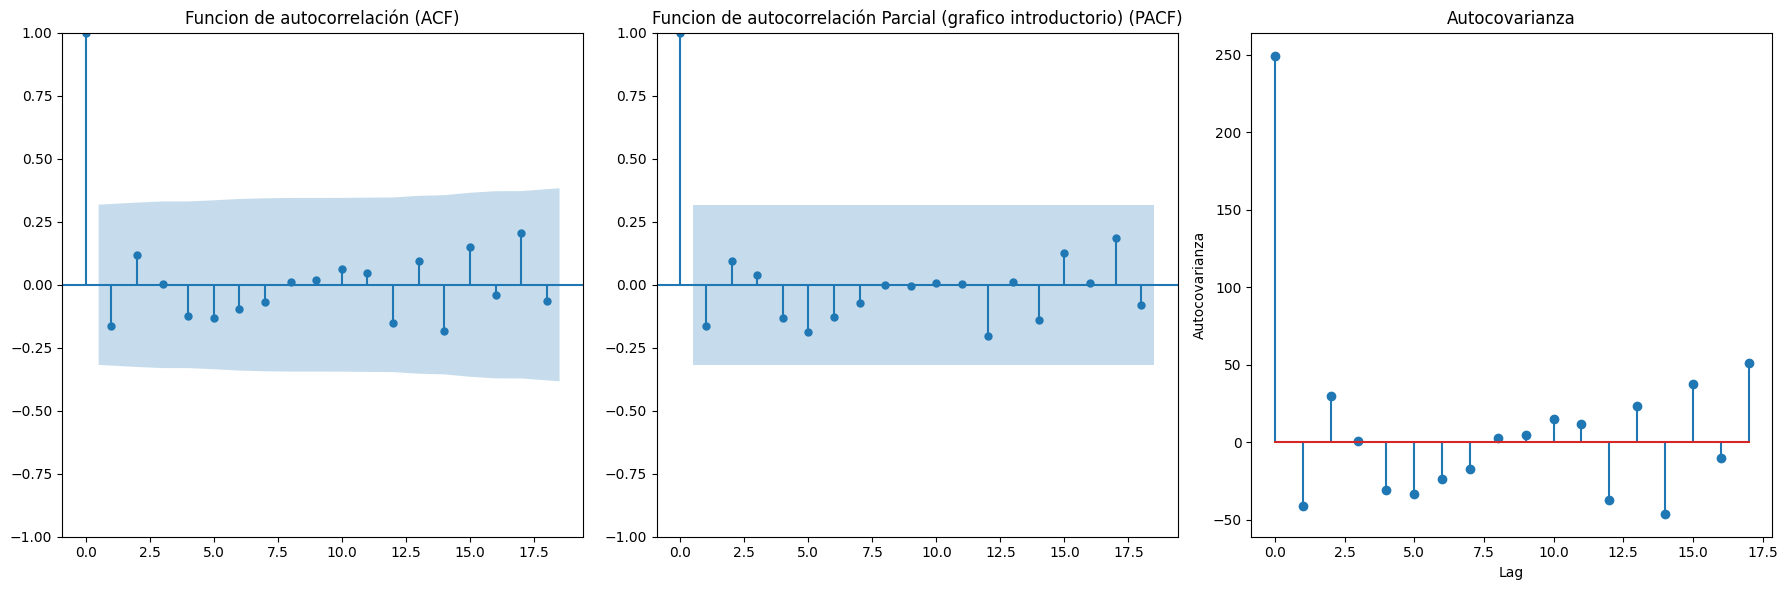

In [43]:
graficar_acf_pacf_autocovarianza(train1_dif, lags=18)

In [44]:
print_test_afd(train1_dif)

Estadistico ADF: -3.461011
p-valor: 0.009047
Valores criticos:
	1%: -3.646
	5%: -2.954
	10%: -2.616


Al hacer la diferencia de orden 1 se puede ver que se obtuvo una serie estacionaria pero que en principio la misma parece ser ruido blanco ya que no tenemos autocovariancias significativas ni en la FAC ni en la FACP

# 4 Planteo de modelos

## 4.1 Ag Barometer AR

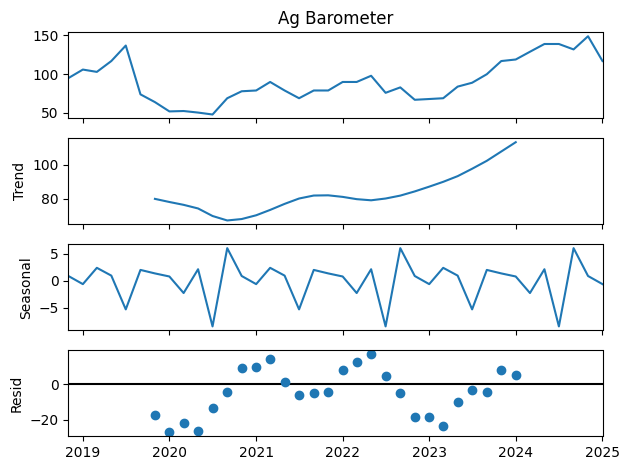

In [86]:
# Descomposición aditiva de la serie
descomposicion = sm.tsa.seasonal_decompose(train1, model="additive", period=12)
descomposicion.plot()
plt.show()

In [47]:
df_dolar = pd.read_csv('../data/clean_data/dolar_full_cleaned.csv') 

df_dolar['Brecha %'] = df_dolar['brecha']/df_dolar['oficial']

df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'], format='%Y-%m-%d')

df_dolar = df_dolar[
    (df_dolar['fecha'] >= '2018-11-01') &
    (df_dolar['fecha'] <= '2025-09-01')
].copy()

df_dolar.set_index('fecha', inplace=True)

dolar = df_dolar['Brecha %']

# Asignamos frecuencia bimestral
dolar = dolar.asfreq('2MS')

In [48]:
df_soja = pd.read_csv('../data/clean_data/precio_soja_chicago_cleaned.csv') 

df_soja['date'] = pd.to_datetime(df_soja['date'], format='%Y-%m-%d')

df_soja.set_index('date', inplace=True)

soja = df_soja['Close']

# Asignamos frecuencia diaria
soja = soja.asfreq('D')

# Completamos los datos
soja = soja.ffill()

# Nos quedamos con los datos del inicio de cada bimestre
soja = soja[soja.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
soja = soja.asfreq('2MS')

In [49]:
df_rem = pd.read_csv('../data/clean_data/rem_cleaned.csv') 

df_rem['Fecha'] = pd.to_datetime(df_rem['Fecha'], format='%Y-%m-%d')

df_rem['Fecha'] = df_rem['Fecha'] + pd.Timedelta(days=1)

df_rem.set_index('Fecha', inplace=True)

rem = df_rem['Valor']

# Nos quedamos con los datos del inicio de cada bimestre
rem = rem[rem.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
rem = rem.asfreq('2MS')

In [50]:
agbarometerUSA = data2[data2.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
agbarometerUSA = agbarometerUSA.asfreq('2MS')

ICG = data3[data3.index.isin(dolar.index)]

# Asignamos frecuencia bimestral
ICG = ICG.asfreq('2MS')

In [51]:
data_completa = pd.concat([data1, agbarometerUSA, dolar, rem, soja, ICG], axis=1)

data_completa.rename(columns={'Ag Barometer': 'Ag Barometer AR', 'Purdue/CME Ag Economy Barometer': 'Ag Barometer USA', 'Brecha %': 'Brecha', 'Valor': 'REM', 'Close': 'Soja', 'value': 'ICG'},
                     inplace = True)

In [52]:
df_prophet = data_completa.reset_index()

df_prophet = df_prophet.rename(columns={
    data_completa.index.name if data_completa.index.name else 'index': 'ds',
    'Ag Barometer AR': 'y'
})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Asignar frecuencia bimestral
df_prophet = df_prophet.set_index('ds').asfreq('2MS').reset_index()

In [53]:
df_train = df_prophet.iloc[:-16].copy()
df_val = df_prophet.iloc[-16:-8].copy()
df_test = df_prophet.iloc[-8:].copy()

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Crear modelo
m = Prophet(interval_width=0.95)

# Agregar regresores
m.add_regressor('Ag Barometer USA')
m.add_regressor('ICG')

# Entrenar
m.fit(df_train)


c:\Users\FBorbiconi\OneDrive - Universidad Austral\Documentos\MCD\Series de tiempo\series_de_tiempo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
08:05:27 - cmdstanpy - INFO - Chain [1] start processing
08:05:27 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Crear dataframe futuro
future = m.make_future_dataframe(periods=len(df_val), freq='2MS')


In [ ]:
# Agregar los valores futuros de los regresores
future = future.merge(
    df_prophet[['ds', 'Soja', 'ICG', 'Brecha', 'REM', 'Ag Barometer USA']],
    on='ds',
    how='left'
)


In [ ]:
# Generar predicciones
forecast = m.predict(future, )

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
29,2023-09-01,66.791391,50.522533,82.626266
30,2023-11-01,45.041485,29.709557,61.104778
31,2024-01-01,11.263966,-4.957357,26.694901
32,2024-03-01,15.333671,-1.981479,30.245596
33,2024-05-01,27.237650,10.751623,42.709593


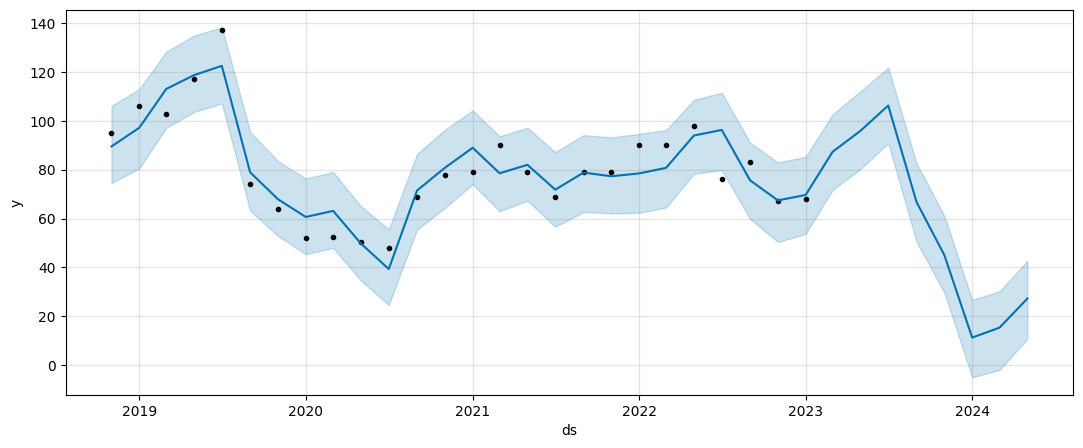

In [ ]:
# Gráfico
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)

m.plot(forecast, ax=ax)

plt.show()

In [ ]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(df_val)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3,2025-01-01,28.589540,12.960352,43.180583
4,2025-03-01,20.244030,4.400146,36.415712
5,2025-05-01,29.481880,13.826760,44.712456
6,2025-07-01,12.356878,-4.234996,29.056480
7,2025-09-01,30.893940,15.991586,45.831348


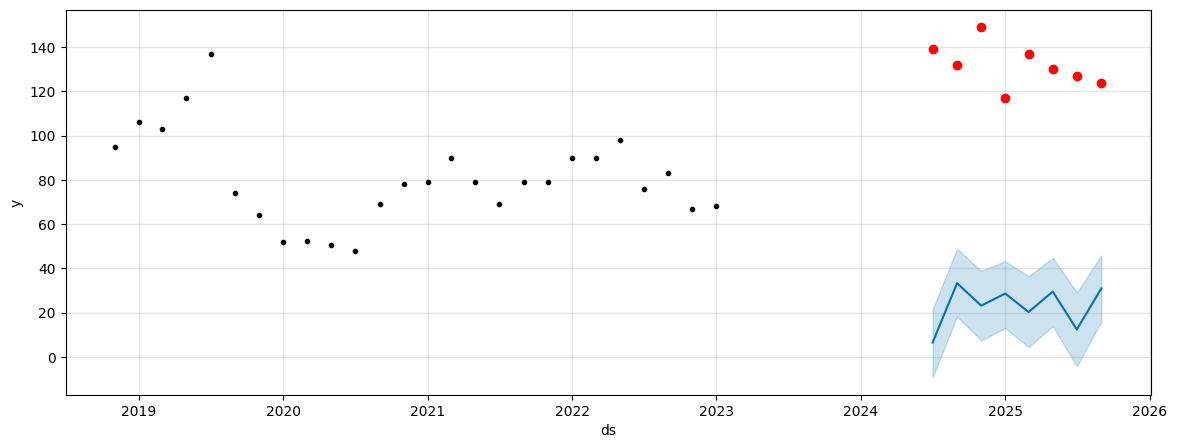

In [ ]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(df_val.ds, df_val['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

In [61]:
# Cálculo de las medidas de precisión

from numpy import sqrt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

rmse = sqrt(mean_squared_error(df_test['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(df_test['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(df_test['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(df_test['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)
mape = mean_absolute_percentage_error(df_test['y'], X_tst_forecast['yhat']) * 100
print('Test MAPE: %.2f%%' % mape)

Test RMSE: 109.844
Test MSE: 12065.718
Test MAE: 108.823
Test R2: -140.767
Test MAPE: 82.26%


In [78]:
resultados_metricas = []

def objective(trial):
    
    train = df_train
    val = df_val
    
    # -------------------------
    # 🔎 Espacio de búsqueda
    # -------------------------
    
    changepoint_prior_scale = trial.suggest_float(
        'changepoint_prior_scale', 0.001, 0.03, log=True
    )
    
    changepoint_range = trial.suggest_float(
        'changepoint_range', 0.7, 0.9
    )
    
    seasonality_prior_scale = trial.suggest_float(
        'seasonality_prior_scale', 1.0, 10.0
    )
    
   
    # Regularización para regresores
    regressor_prior_scale = trial.suggest_float(
        'regressor_prior_scale', 0.01, 2.0, log=True
    )
    
    # -------------------------
    # 📈 Modelo
    # -------------------------
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode='additive',
        interval_width=0.95
    )
    
    # Agregar regresores con prior optimizable
    model.add_regressor('Ag Barometer USA', prior_scale=regressor_prior_scale)
    model.add_regressor('ICG', prior_scale=regressor_prior_scale)
    
    model.fit(train)
    
    # -------------------------
    # 🔮 Predicción correcta
    # -------------------------
    
    # Concatenamos train + test para mantener regresores alineados
    future = pd.concat([train, val])
    
    forecast = model.predict(future)
    
    pred = forecast.tail(len(val)).copy()
    
    # -------------------------
    # 📊 Métricas
    # -------------------------
    
    rmse = sqrt(mean_squared_error(val['y'], pred['yhat']))
    mae = mean_absolute_error(val['y'], pred['yhat'])
    mse = mean_squared_error(val['y'], pred['yhat'])
    r2 = r2_score(val['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(val['y'], pred['yhat']) * 100
    
    resultados_metricas.append({
        'trial': trial.number,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'MAPE': mape,
        **trial.params
    })
    
    return mape


In [79]:
import optuna

sampler = optuna.samplers.TPESampler(seed=2517)
# Ejecutar optimización
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2026-02-19 08:33:53,667] A new study created in memory with name: no-name-a6d3ac10-e2a5-4d8b-be0b-faf88a3d1e17
08:33:54 - cmdstanpy - INFO - Chain [1] start processing
08:33:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 08:33:54,650] Trial 0 finished with value: 51.46695810680494 and parameters: {'changepoint_prior_scale': 0.008408128229706014, 'changepoint_range': 0.8624403253406522, 'seasonality_prior_scale': 6.557920773836885, 'regressor_prior_scale': 0.9011107426297809}. Best is trial 0 with value: 51.46695810680494.
08:33:55 - cmdstanpy - INFO - Chain [1] start processing
08:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 08:33:55,554] Trial 1 finished with value: 46.405377731583215 and parameters: {'changepoint_prior_scale': 0.013481133455343634, 'changepoint_range': 0.8692512349363097, 'seasonality_prior_scale': 2.5526431889652588, 'regressor_prior_scale': 0.019349674604345155}. Best is trial 1 with value: 46.405377731583215.
08:33:55 - cm

In [80]:
study.best_params

{'changepoint_prior_scale': 0.0018578054767039406,
 'changepoint_range': 0.72332804143218,
 'seasonality_prior_scale': 5.197557028122752,
 'regressor_prior_scale': 0.013333883912926751}

In [81]:
def graficar_mejor_modelo(study):

    train = df_train
    val = df_val
    test = df_test

    best_params = study.best_params

    # -------------------------
    # 📈 Modelo con mejores hiperparámetros
    # -------------------------
    
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        changepoint_range=best_params['changepoint_range'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode='additive',
        interval_width=0.95
    )

    # 🔹 Agregar regresores
    model.add_regressor(
        'Ag Barometer USA',
        prior_scale=best_params['regressor_prior_scale']
    )
    model.add_regressor(
        'ICG',
        prior_scale=best_params['regressor_prior_scale']
    )

    final_train = pd.concat([train, val])

    model.fit(final_train)

    # -------------------------
    # 🔮 Predicción correcta
    # -------------------------
    
    future = pd.concat([train, val, test])
    forecast = model.predict(future)

    pred = forecast.tail(len(test)).copy()

    # -------------------------
    # 📊 Métricas
    # -------------------------
    
    rmse = sqrt(mean_squared_error(test['y'], pred['yhat']))
    mae = mean_absolute_error(test['y'], pred['yhat'])
    mse = mean_squared_error(test['y'], pred['yhat'])
    r2 = r2_score(test['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(test['y'], pred['yhat']) * 100

    print("\n📊 Métricas del mejor modelo Prophet optimizado:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"R²  : {r2:.3f}")
    print(f"MAPE: {mape:.2f}%")

    # -------------------------
    # 📈 Gráfico
    # -------------------------
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(14)

    ax.scatter(final_train['ds'], final_train['y'],
               color='black', alpha=0.5,
               label='Train (real)', marker='.')

    ax.scatter(test['ds'], test['y'],
               color='red', alpha=0.7,
               label='Test (real)', marker='.')

    model.plot(forecast, ax=ax)

    ax.set_title('Mejor modelo Prophet optimizado con regresores')
    ax.legend()
    plt.grid(True)
    plt.show()

    return rmse, mae, mse, r2, mape


08:35:51 - cmdstanpy - INFO - Chain [1] start processing
08:35:52 - cmdstanpy - INFO - Chain [1] done processing



📊 Métricas del mejor modelo Prophet optimizado:
RMSE: 47.85
MAE : 44.10
MSE : 2289.87
R²  : -25.905
MAPE: 32.91%


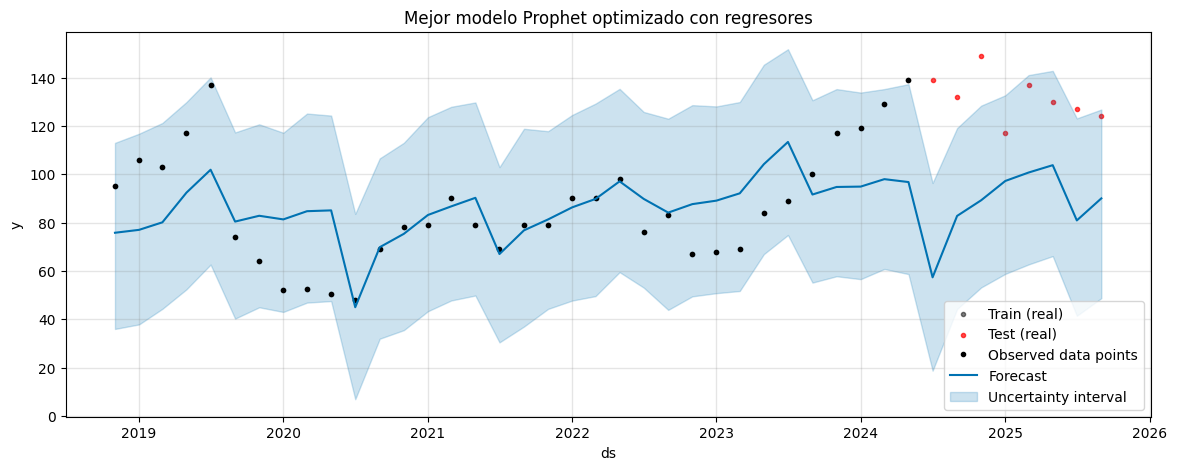

(np.float64(47.85258250057529),
 44.104229294256655,
 2289.8696519743644,
 -25.905022531000427,
 32.90969991518028)

In [82]:
# Mostrar gráfico del mejor modelo
graficar_mejor_modelo(study)

## 4.2 Ag Barometer USA

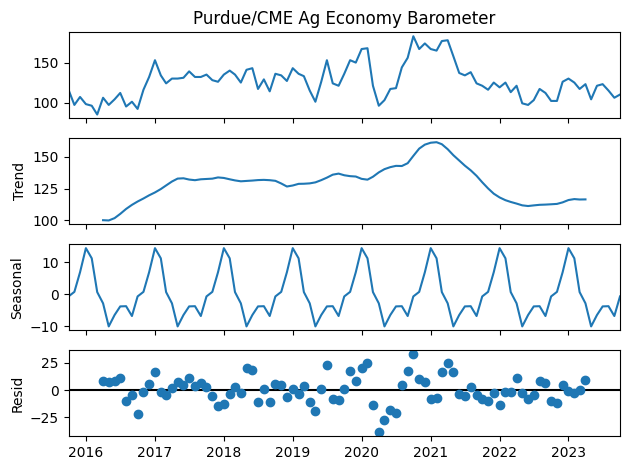

In [91]:
# Descomposición aditiva de la serie
descomposicion = sm.tsa.seasonal_decompose(train2, model="additive", period=12)
descomposicion.plot()
plt.show()

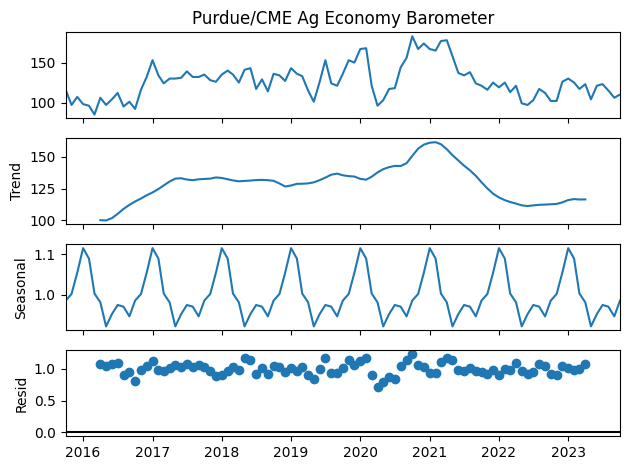

In [92]:
# Descomposición multiplicativa de la serie
descomposicion = sm.tsa.seasonal_decompose(train2, model="multiplicative", period=12)
descomposicion.plot()
plt.show()

In [93]:
# Convertir la serie a formato Prophet

df_prophet_2 = data2.rename("y").to_frame()
df_prophet_2 = df_prophet_2.reset_index().rename(columns={"Date": "ds"})


In [94]:
# Dividir en train, validación y test
n = len(df_prophet_2)

train_end = int(n * 0.6)
val_end = int(n * 0.8)

df_train_2 = df_prophet_2.iloc[:train_end].copy()
df_val_2   = df_prophet_2.iloc[train_end:val_end].copy()
df_test_2  = df_prophet_2.iloc[val_end:].copy()

In [95]:
# Se definen como holidays los noviembres 2016, 2020 y 2024, meses de las elecciones presidenciales de USA (Más un efecto de ventana de 5 meses)
holidays = pd.DataFrame({
    'holiday': 'evento_especial',
    'ds': pd.to_datetime([
        '2016-11-01',
        '2016-12-01',
        '2017-01-01',
        '2017-02-01',
        '2017-03-01',
        '2017-04-01',
        '2020-11-01',
        '2020-12-01',
        '2021-01-01',
        '2021-02-01',
        '2021-03-01',
        '2021-04-01',
        '2024-11-01',
        '2024-12-01',
        '2025-01-01',
        '2025-02-01',
        '2025-03-01',
        '2025-04-01'
    ]),
    'lower_window': 0,
    'upper_window': 1
})

In [96]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [97]:
m = Prophet(interval_width=0.95, holidays=holidays, holidays_prior_scale=10)
m.fit(df_train_2)

08:57:37 - cmdstanpy - INFO - Chain [1] start processing
08:57:38 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
# Se define la cantidad de períodos a predecir
future = m.make_future_dataframe(periods=len(df_val_2), freq='MS')

In [99]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2023-05-01,150.707361,125.126296,180.744605
92,2023-06-01,164.712020,137.601367,191.023423
93,2023-07-01,174.379915,148.724844,201.375726
94,2023-08-01,160.767559,132.084949,186.901340
95,2023-09-01,150.213421,123.728778,177.593607


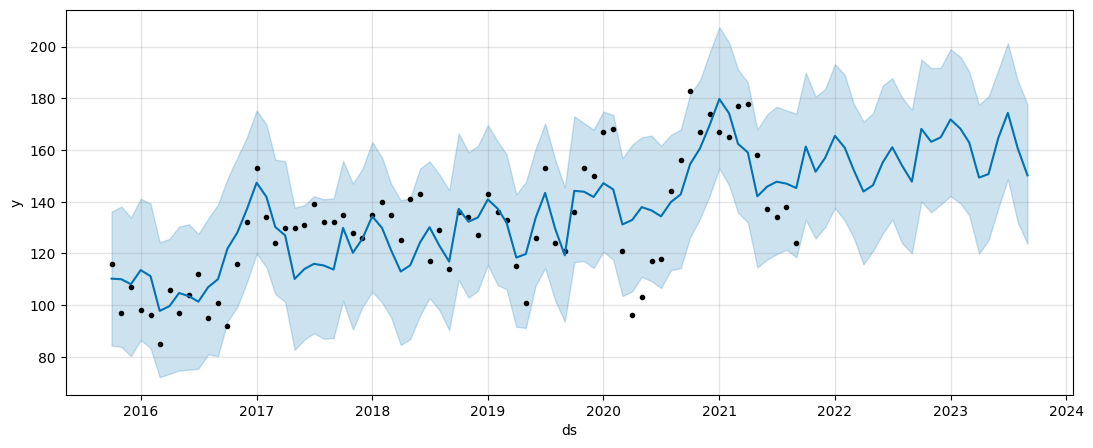

In [100]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

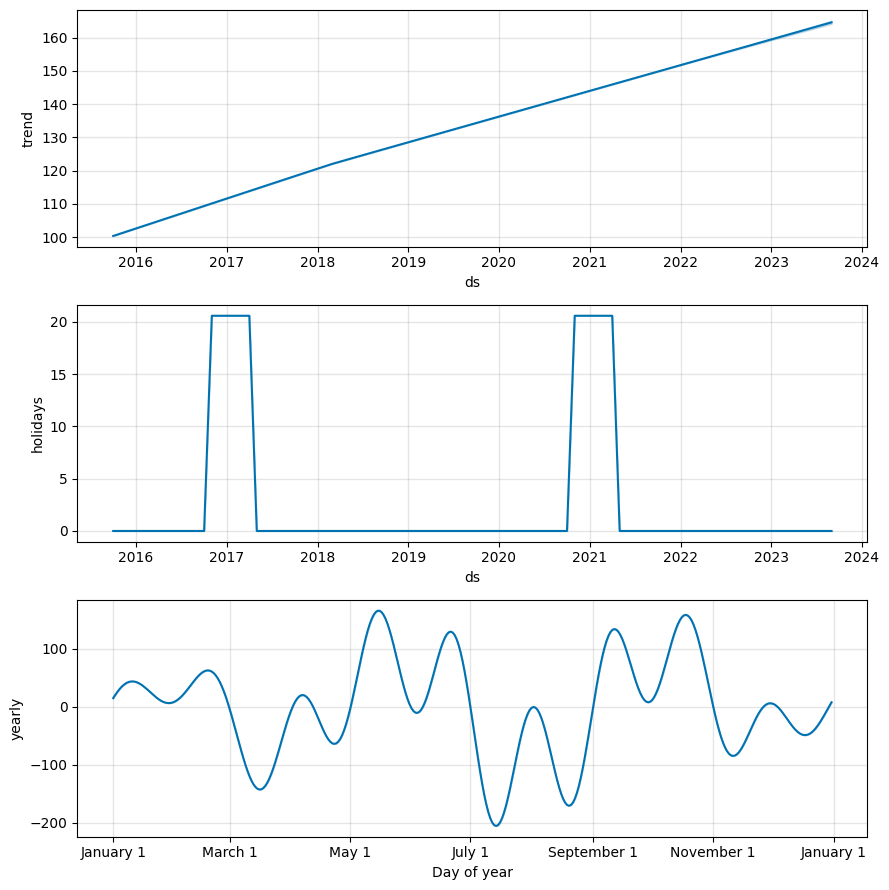

In [101]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

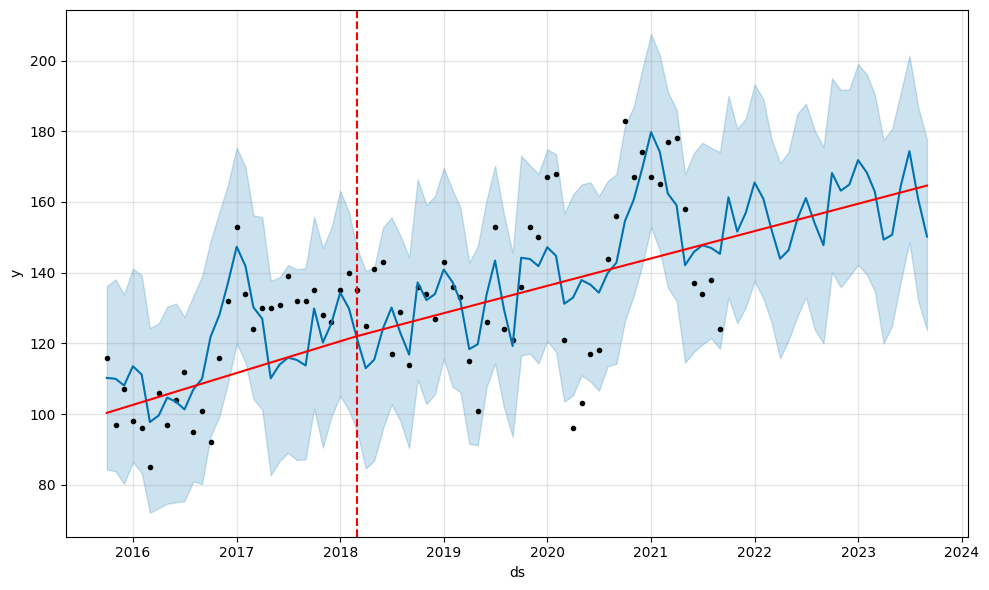

In [102]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [103]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(df_val_2)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,2023-05-01,150.707361,121.497818,178.283960
20,2023-06-01,164.712020,139.220538,194.904611
21,2023-07-01,174.379915,145.264652,202.735065
22,2023-08-01,160.767559,132.421681,187.932263
23,2023-09-01,150.213421,123.763533,176.893124


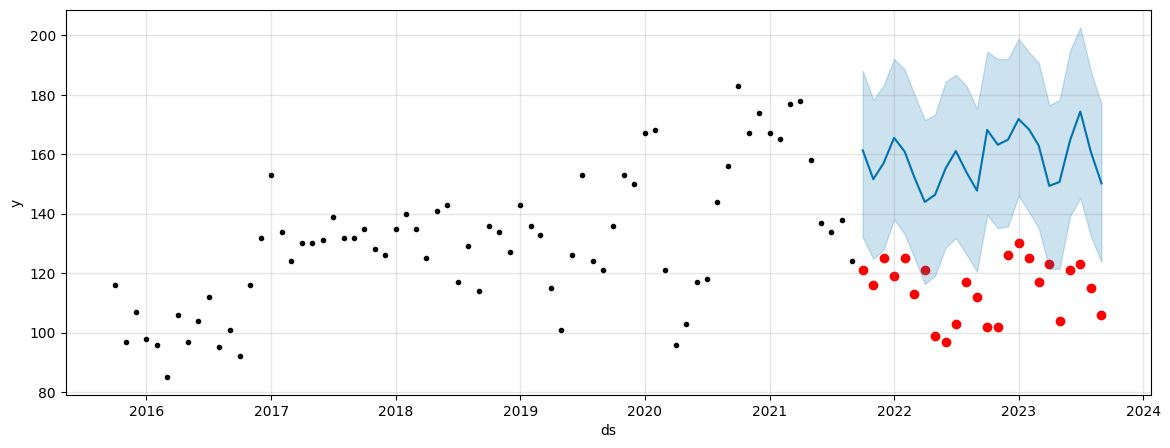

In [104]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(df_val_2.ds, df_val_2['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

In [105]:
# Cálculo de las medidas de precisión

from numpy import sqrt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

rmse = sqrt(mean_squared_error(df_val_2['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(df_val_2['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(df_val_2['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(df_val_2['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)
mape = mean_absolute_percentage_error(df_val_2['y'], X_tst_forecast['yhat']) * 100
print('Test MAPE: %.2f%%' % mape)

Test RMSE: 44.699
Test MSE: 1998.020
Test MAE: 43.524
Test R2: -20.958
Test MAPE: 38.61%


In [106]:
resultados_metricas = []

def objective(trial):
    train = df_train_2
    val = df_val_2

    # Espacio de búsqueda
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log = True)
    changepoint_range = trial.suggest_float('changepoint_range', 0.7, 1.0)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 1.0, 20.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 7, 13, log=True)

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        interval_width=0.95,
        holidays=holidays,
        holidays_prior_scale=holidays_prior_scale
    )
    model.fit(train)

    future = model.make_future_dataframe(periods=len(val), freq='MS')
    forecast = model.predict(future)
    pred = forecast[-len(val):].copy()

    rmse = sqrt(mean_squared_error(val['y'], pred['yhat']))
    mae = mean_absolute_error(val['y'], pred['yhat'])
    mse = mean_squared_error(val['y'], pred['yhat'])
    r2 = r2_score(val['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(val['y'], pred['yhat']) * 100
    
    resultados_metricas.append({
        'trial': trial.number,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'MAPE': mape,
        **trial.params
    })

    return mape

In [107]:
import optuna

sampler = optuna.samplers.TPESampler(seed=5647)
# Ejecutar optimización
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2026-02-19 08:57:44,927] A new study created in memory with name: no-name-723e9a2e-b0da-457d-bec9-bbcbc4e64017
08:57:45 - cmdstanpy - INFO - Chain [1] start processing
08:57:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 08:57:45,478] Trial 0 finished with value: 40.5765004583214 and parameters: {'changepoint_prior_scale': 0.008060498596826718, 'changepoint_range': 0.7292139941586582, 'seasonality_prior_scale': 15.52285801331399, 'seasonality_mode': 'additive', 'holidays_prior_scale': 7.676377092542629}. Best is trial 0 with value: 40.5765004583214.
08:57:45 - cmdstanpy - INFO - Chain [1] start processing
08:57:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 08:57:46,129] Trial 1 finished with value: 33.61129359431489 and parameters: {'changepoint_prior_scale': 0.1083193216868636, 'changepoint_range': 0.7245056909235145, 'seasonality_prior_scale': 11.291735099302626, 'seasonality_mode': 'additive', 'holidays_prior_scale': 9.365644643673855}. Best is 

In [108]:
study.best_params

{'changepoint_prior_scale': 0.2534578006130238,
 'changepoint_range': 0.7162275379275113,
 'seasonality_prior_scale': 11.890084083524645,
 'seasonality_mode': 'multiplicative',
 'holidays_prior_scale': 12.674602867262783}

In [109]:
def graficar_mejor_modelo(study):

    train = df_train_2
    val = df_val_2
    test = df_test_2

    best_params = study.best_params
    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        changepoint_range=best_params['changepoint_range'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        interval_width=0.95,
        holidays=holidays,
        holidays_prior_scale=best_params['holidays_prior_scale']
    )

    final_train = pd.concat([train, val])
    model.fit(final_train)

    future = model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = model.predict(future)
    pred = forecast[-len(test):].copy()

    # Métricas
    rmse = sqrt(mean_squared_error(test['y'], pred['yhat']))
    mae = mean_absolute_error(test['y'], pred['yhat'])
    mse = mean_squared_error(test['y'], pred['yhat'])
    r2 = r2_score(test['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(test['y'], pred['yhat']) * 100

    print("\n📊 Métricas del mejor modelo Prophet optimizado:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"R²  : {r2:.3f}")
    print(f"MAPE: {mape:.2f}%")

    # Gráfico
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(14)
    ax.scatter(final_train['ds'], final_train['y'], color='black', alpha=0.5, label='Train (real)', marker='.')
    ax.scatter(test['ds'], test['y'], color='red', alpha=0.7, label='Test (real)', marker='.')
    model.plot(forecast, ax=ax)
    ax.set_title(f'Mejor modelo Prophet optimizado')
    ax.legend()
    plt.grid(True)
    plt.show()

    return rmse, mae, mse, r2, mape

08:59:35 - cmdstanpy - INFO - Chain [1] start processing
08:59:36 - cmdstanpy - INFO - Chain [1] done processing



📊 Métricas del mejor modelo Prophet optimizado:
RMSE: 29.89
MAE : 22.89
MSE : 893.16
R²  : -1.612
MAPE: 17.13%


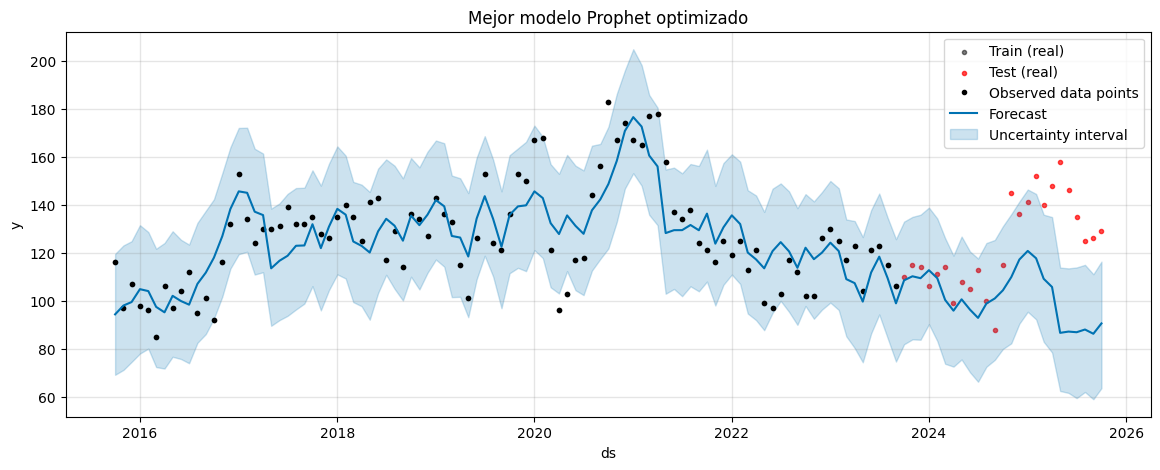

(np.float64(29.885808227717206),
 22.89155450831181,
 893.1615334238895,
 -1.6117789326449268,
 17.134300501384267)

In [110]:
# Mostrar gráfico del mejor modelo
graficar_mejor_modelo(study)

## 4.3 ICG - UTDT

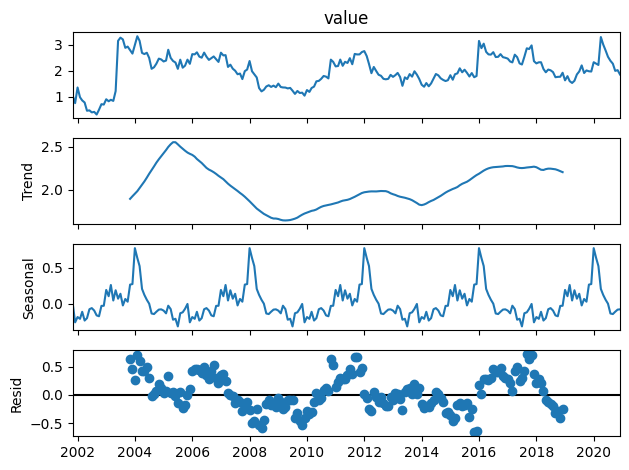

In [113]:
# Descomposición aditiva de la serie
descomposicion = sm.tsa.seasonal_decompose(train3, model="additive", period=48)
descomposicion.plot()
plt.show()

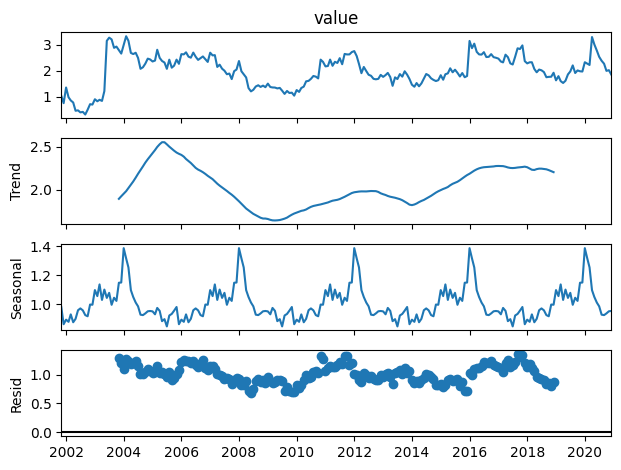

In [114]:
# Descomposición multiplicativa de la serie
descomposicion = sm.tsa.seasonal_decompose(train3, model="multiplicative", period=48)
descomposicion.plot()
plt.show()

In [115]:
# Convertir la serie a formato Prophet

df_prophet_3 = data3.rename("y").to_frame()
df_prophet_3 = df_prophet_3.reset_index().rename(columns={"date": "ds"})


In [116]:
# Dividir en train, validación y test
n = len(df_prophet_3)

train_end = int(n * 0.6)
val_end = int(n * 0.8)

df_train_3 = df_prophet_3.iloc[:train_end].copy()
df_val_3   = df_prophet_3.iloc[train_end:val_end].copy()
df_test_3  = df_prophet_3.iloc[val_end:].copy()

In [117]:
m = Prophet(interval_width=0.95,
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False)

# Agregar estacionalidad de 4 años
m.add_seasonality(
    name='four_year_cycle',
    period=1461,     # 4 años en días
    fourier_order=5  # complejidad moderada
)

# Ahora sí entrenar
m.fit(df_train_3)

09:37:35 - cmdstanpy - INFO - Chain [1] start processing
09:37:35 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
# Se define la cantidad de períodos a predecir
future = m.make_future_dataframe(periods=len(df_val_3), freq='MS')

In [119]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
225,2020-08-01,1.512643,0.581021,2.556466
226,2020-09-01,1.488615,0.444992,2.571990
227,2020-10-01,1.518654,0.468013,2.564553
228,2020-11-01,1.581597,0.609821,2.606106
229,2020-12-01,1.645214,0.589752,2.723586


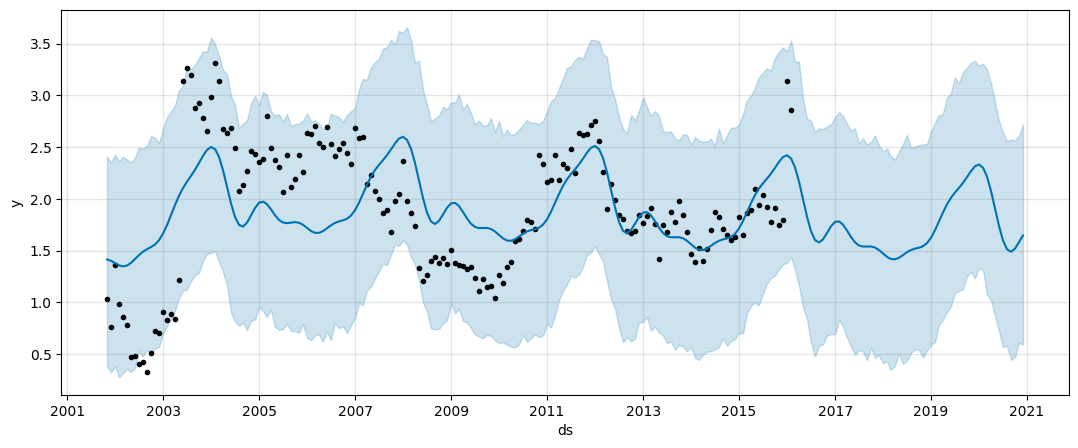

In [120]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

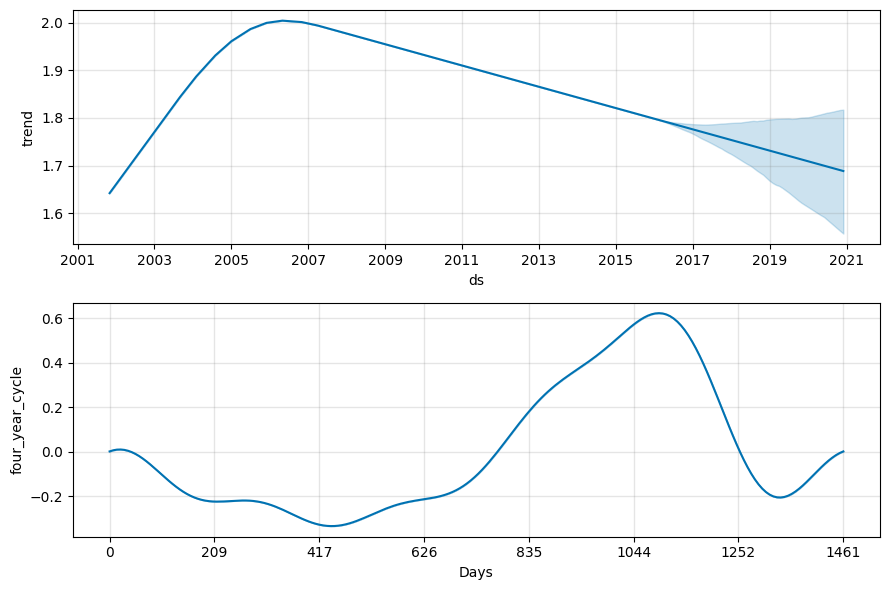

In [121]:
# Se grafican las componenestes de las predicciones
fig2 = m.plot_components(forecast)

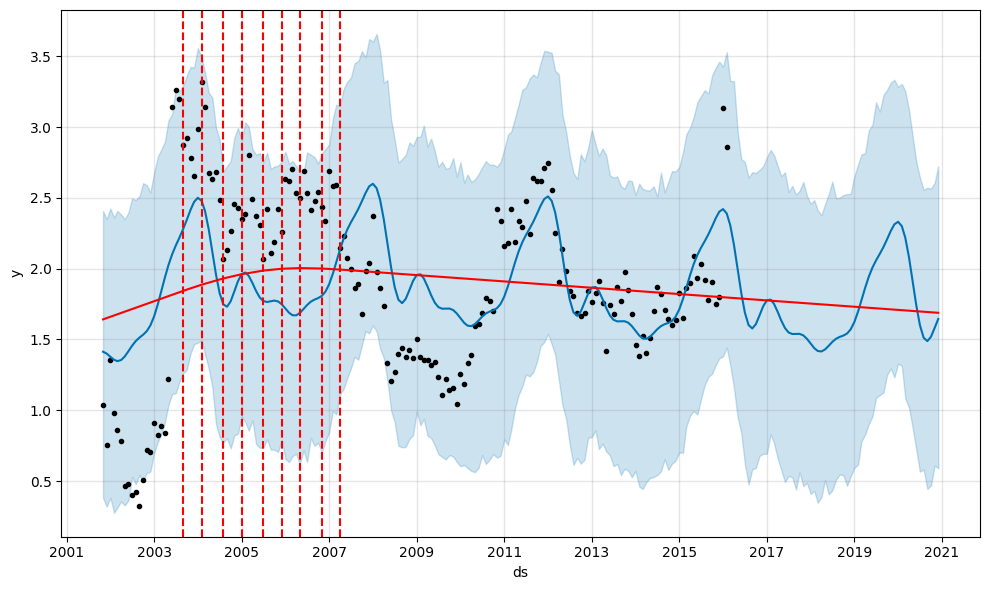

In [122]:
# Se grafican los puntos de cambio
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [123]:
# Se generan las predicciones para la base de testeo
X_tst_forecast = m.predict(df_val_3)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
53,2020-08-01,1.512643,0.472992,2.518117
54,2020-09-01,1.488615,0.502841,2.481865
55,2020-10-01,1.518654,0.529648,2.572577
56,2020-11-01,1.581597,0.567592,2.622614
57,2020-12-01,1.645214,0.594249,2.661894


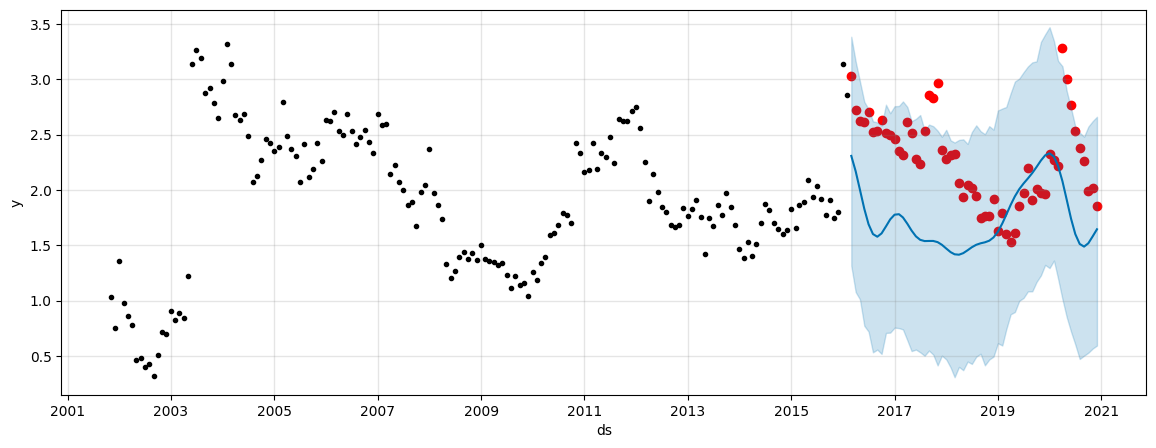

In [124]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(14)
ax.scatter(df_val_3.ds, df_val_3['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)

In [125]:
# Cálculo de las medidas de precisión

from numpy import sqrt
from sklearn.metrics import mean_absolute_percentage_error, r2_score

rmse = sqrt(mean_squared_error(df_val_3['y'], X_tst_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
mse = mean_squared_error(df_val_3['y'], X_tst_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(df_val_3['y'], X_tst_forecast['yhat'])
print('Test MAE: %.3f' % mae)
r2 = r2_score(df_val_3['y'], X_tst_forecast['yhat'])
print('Test R2: %.3f' % r2)
mape = mean_absolute_percentage_error(df_val_3['y'], X_tst_forecast['yhat']) * 100
print('Test MAPE: %.2f%%' % mape)

Test RMSE: 0.705
Test MSE: 0.497
Test MAE: 0.601
Test R2: -2.119
Test MAPE: 24.96%


In [142]:
resultados_metricas = []

def objective(trial):
    train = df_train_3
    val = df_val_3

    # Espacio de búsqueda
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    changepoint_range = trial.suggest_float('changepoint_range', 0.7, 1.0)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 1.0, 20.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # 🔹 Nuevo: optimizar complejidad del ciclo de 4 años
    fourier_order_4y = trial.suggest_int('fourier_order_4y', 3, 8)

    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
        interval_width=0.95,
        yearly_seasonality=False,   # si querés solo el ciclo largo
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # 🔹 Agregar ciclo de 4 años
    model.add_seasonality(
        name='four_year_cycle',
        period=1461,          # 4 años en días
        fourier_order=fourier_order_4y
    )

    model.fit(train)

    future = model.make_future_dataframe(periods=len(val), freq='MS')
    forecast = model.predict(future)
    pred = forecast[-len(val):].copy()

    rmse = sqrt(mean_squared_error(val['y'], pred['yhat']))
    mae = mean_absolute_error(val['y'], pred['yhat'])
    mse = mean_squared_error(val['y'], pred['yhat'])
    r2 = r2_score(val['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(val['y'], pred['yhat']) * 100

    resultados_metricas.append({
        'trial': trial.number,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'MAPE': mape,
        **trial.params
    })

    return mape


In [143]:
import optuna

sampler = optuna.samplers.TPESampler(seed=366879)
# Ejecutar optimización
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2026-02-19 10:01:29,874] A new study created in memory with name: no-name-67b3bd72-0cd4-4665-9fc7-6aa9da9f4873
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 10:01:30,316] Trial 0 finished with value: 25.355419132930805 and parameters: {'changepoint_prior_scale': 0.05941178953073289, 'changepoint_range': 0.7114588662351489, 'seasonality_prior_scale': 16.45966668309106, 'seasonality_mode': 'additive', 'fourier_order_4y': 3}. Best is trial 0 with value: 25.355419132930805.
10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2026-02-19 10:01:30,842] Trial 1 finished with value: 23.476291368183638 and parameters: {'changepoint_prior_scale': 0.00855421729842832, 'changepoint_range': 0.8339660340781307, 'seasonality_prior_scale': 19.095191727596468, 'seasonality_mode': 'multiplicative', 'fourier_order_4y': 4}. Best is trial 1 with value: 23.476291

In [146]:
study.best_params

{'changepoint_prior_scale': 0.009000825646257414,
 'changepoint_range': 0.7844988602309423,
 'seasonality_prior_scale': 10.14470068591693,
 'seasonality_mode': 'multiplicative',
 'fourier_order_4y': 3}

In [144]:
def graficar_mejor_modelo(study):

    train = df_train_3
    val = df_val_3
    test = df_test_3

    best_params = study.best_params

    model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        changepoint_range=best_params['changepoint_range'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        interval_width=0.95,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # 🔹 Si permitiste que Optuna decida usar el ciclo
    if best_params.get('use_4y_cycle', True):

        model.add_seasonality(
            name='four_year_cycle',
            period=1461,
            fourier_order=best_params['fourier_order_4y']
        )

    final_train = pd.concat([train, val])
    model.fit(final_train)

    future = model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = model.predict(future)
    pred = forecast[-len(test):].copy()

    # Métricas
    rmse = sqrt(mean_squared_error(test['y'], pred['yhat']))
    mae = mean_absolute_error(test['y'], pred['yhat'])
    mse = mean_squared_error(test['y'], pred['yhat'])
    r2 = r2_score(test['y'], pred['yhat'])
    mape = mean_absolute_percentage_error(test['y'], pred['yhat']) * 100

    print("\n📊 Métricas del mejor modelo Prophet optimizado:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"R²  : {r2:.3f}")
    print(f"MAPE: {mape:.2f}%")

    # Gráfico
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(14)

    ax.scatter(final_train['ds'], final_train['y'], color='black', alpha=0.5, label='Train (real)', marker='.')
    ax.scatter(test['ds'], test['y'], color='red', alpha=0.7, label='Test (real)', marker='.')

    model.plot(forecast, ax=ax)

    ax.set_title('Mejor modelo Prophet optimizado')
    ax.legend()
    plt.grid(True)
    plt.show()

    return rmse, mae, mse, r2, mape


10:02:29 - cmdstanpy - INFO - Chain [1] start processing
10:02:29 - cmdstanpy - INFO - Chain [1] done processing



📊 Métricas del mejor modelo Prophet optimizado:
RMSE: 0.60
MAE : 0.48
MSE : 0.35
R²  : -0.145
MAPE: 34.36%


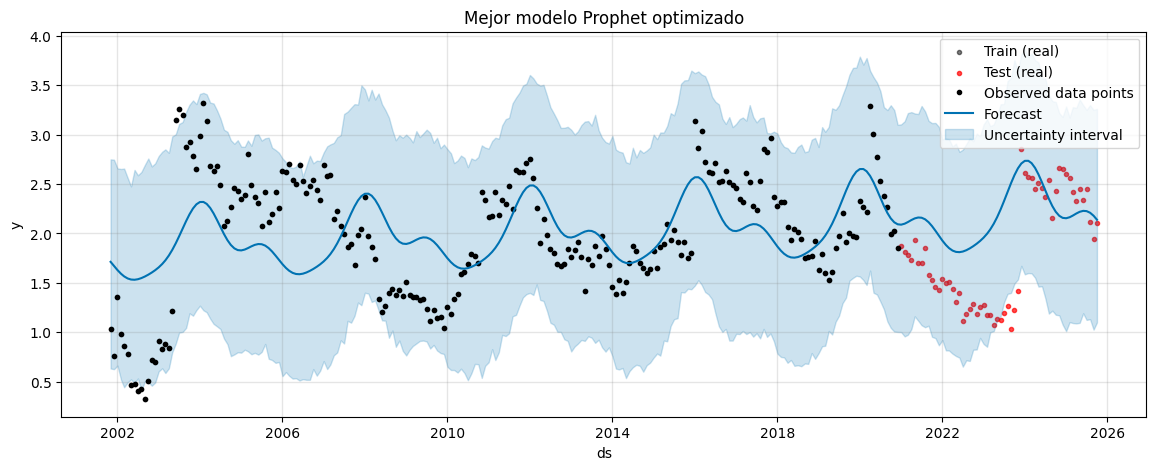

(np.float64(0.5953000772388354),
 0.47891023954898826,
 0.3543821819605633,
 -0.14498396619588516,
 34.36089179214748)

In [145]:
# Mostrar gráfico del mejor modelo
graficar_mejor_modelo(study)

In [ ]:
print(len(df_val_2))
print(len(df_test_2))

24
25
